In [38]:
!pip install torch>=1.2.0

In [39]:
!unzip text-dependent-dataset-split.zip -d /content/dataset

Archive:  text-dependent-dataset-split.zip
replace /content/dataset/testing/0/gio.audiocapture_1.wav.3pkg1fpg.ingestion-b564784b5-sv74p.s10.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/dataset/testing/0/gio.audiocapture_1.wav.3pkg1fpg.ingestion-b564784b5-sv74p.s10.wav  
  inflating: /content/dataset/testing/0/gio.audiocapture_1.wav.3pkg1fpg.ingestion-b564784b5-sv74p.s11.wav  
  inflating: /content/dataset/testing/0/gio.audiocapture_1.wav.3pkg1fpg.ingestion-b564784b5-sv74p.s12.wav  
  inflating: /content/dataset/testing/0/gio.audiocapture_1.wav.3pkg1fpg.ingestion-b564784b5-sv74p.s13.wav  
  inflating: /content/dataset/testing/0/gio.audiocapture_1.wav.3pkg1fpg.ingestion-b564784b5-sv74p.s14.wav  
  inflating: /content/dataset/testing/0/gio.audiocapture_1.wav.3pkg1fpg.ingestion-b564784b5-sv74p.s3.wav  
  inflating: /content/dataset/testing/0/gio.audiocapture_1.wav.3pkg1fpg.ingestion-b564784b5-sv74p.s4.wav  
  inflating: /content/dataset/testing/0/gio.audiocapture_1.wa

In [40]:
import torch # This is all you need to use both PyTorch and TorchScript!
import numpy as np
import shutil
import os

print(torch.__version__)

2.0.0+cu118


In [41]:
import torchaudio

wav2mel = torch.jit.load("wav2mel.pt")
dvector = torch.jit.load("dvector.pt").eval()

wav_tensor, sample_rate = torchaudio.load("/content/dataset/testing/0/gio.audiocapture_1.wav.3pkg1fpg.ingestion-b564784b5-sv74p.s10.wav")
mel_tensor = wav2mel(wav_tensor, sample_rate)  # shape: (frames, mel_dim)
emb_tensor = dvector.embed_utterance(mel_tensor)  # shape: (emb_dim)

np_emb = emb_tensor.detach().numpy()
print(np_emb.shape)

(256,)


# Testing of Best Match Cosine Similarity

In [54]:
def getSampleList(directory):
  samplelist = []
  for r, d, file in os.walk(directory):
    for f in file:
      if '.wav' in f:
        samplelist.append(os.path.join(r, f))
  return samplelist

def extract_train_embeddings(file_list):
  embeddings = []
  for f in file_list:
    wav_tensor, sample_rate = torchaudio.load(f)
    mel_tensor = wav2mel(wav_tensor, sample_rate)  # shape: (frames, mel_dim)
    emb_tensor = dvector.embed_utterance(mel_tensor)  # shape: (emb_dim)
    np_emb = emb_tensor.detach().numpy()
    embeddings.append(np_emb)
  return embeddings

def extract_test_embeddings(file_list):
  embeddings = []
  labels = []
  for f in file_list:
    wav_tensor, sample_rate = torchaudio.load(f)
    mel_tensor = wav2mel(wav_tensor, sample_rate)  # shape: (frames, mel_dim)
    emb_tensor = dvector.embed_utterance(mel_tensor)  # shape: (emb_dim)
    np_emb = emb_tensor.detach().numpy()
    embeddings.append(np_emb)
    if("testing/0" in f):
      labels.append(0)
    if("testing/1" in f):
      labels.append(1)
    if("testing/2" in f):
      labels.append(2)
    if("testing/3" in f):
      labels.append(3)
  return embeddings, labels

def extract_val_embeddings(file_list):
  embeddings = []
  labels = []
  for f in file_list:
    wav_tensor, sample_rate = torchaudio.load(f)
    mel_tensor = wav2mel(wav_tensor, sample_rate)  # shape: (frames, mel_dim)
    emb_tensor = dvector.embed_utterance(mel_tensor)  # shape: (emb_dim)
    np_emb = emb_tensor.detach().numpy()
    embeddings.append(np_emb)
    if("validation/0" in f):
      labels.append(0)
    if("validation/1" in f):
      labels.append(1)
    if("validation/2" in f):
      labels.append(2)
    if("validation/3" in f):
      labels.append(3)
  return embeddings, labels

In [146]:
# Loading datasets
train_dir = "/content/dataset/training/enroll-64/3"
training_list = getSampleList(train_dir)
x_train = extract_train_embeddings(training_list)

test_dir = "/content/dataset/testing"
testing_list = getSampleList(test_dir)
x_test, y_test = extract_test_embeddings(testing_list)

val_dir = "/content/dataset/validation"
validation_list = getSampleList(val_dir)
x_val, y_val = extract_val_embeddings(validation_list)

auth_class = 3
train_size=64

Definition of Cosine Similarity method:

In [147]:
def cosine_similarity(vec1, vec2):
  dot_product = np.dot(vec1, vec2)
  norm_vec1 = np.linalg.norm(vec1)
  norm_vec2 = np.linalg.norm(vec2)
  return dot_product / (norm_vec1 * norm_vec2)

vec1 = np.array([6, 7, 8, 9, 10])
vec2 = np.array([6, 7, 8, 9, 10])
cs = cosine_similarity(vec1, vec2)
print("Testing of cosine similarity function...")
print(cs)

def compute_similarity(input_vector, d_vectors):
  
  similarities = []

  for dv in d_vectors:
    similarity = cosine_similarity(input_vector, dv)
    similarities.append(similarity)

  return max(similarities)

Testing of cosine similarity function...
1.0


Prediction function:

In [148]:
def predictDVector(d_vectors,authlabel,input_data, input_labels, threshold, verbose=True):
  
  input_vectors = input_data
  total = len(input_vectors)
  total_auth = 0
  total_denied = 0

  for i in range(len(input_labels)):
    if(input_labels[i]!=auth_class):
      total_denied = total_denied+1
    else:
      total_auth = total_auth + 1

  correct_auth=0
  correct_denied=0

  for i in range(len(input_vectors)):
    similarity=compute_similarity(input_vectors[i], d_vectors)
    result = " -- ERROR!"
    if(similarity>threshold and input_labels[i] == authlabel):
      correct_auth = correct_auth + 1
      result = ""
    if(similarity<=threshold and input_labels[i] != authlabel):
      correct_denied = correct_denied + 1
      result = ""
    if(verbose):
      print("similarity: " + str(similarity) + " --- Class: " + str(input_labels[i]) + " " + result)
  correct = correct_auth + correct_denied

  print('-----------------------')
  print(" --- Testing Results ---")
  true_positive = correct_auth
  false_positive = total_denied - correct_denied
  false_negative = total_auth - correct_auth
  prec = true_positive / (true_positive + false_positive)
  recall = true_positive / (true_positive + false_negative)

  print("True Positive Rate: " + str(correct_auth) + "/" + str(total_auth) + " (" + str(correct_auth*100/total_auth) + "%)")
  print("False Positive Rate: " + str(false_positive) + "/" + str(total_denied) + " (" + str((false_positive)*100/total_denied) + "%)")
  print("Precision: " + str(prec))
  print("Recall: " + str(recall))
  print('******************')
  print("Total correct " + str(correct) + "/" + str(total))
  print("Accuracy on this dataset: " + str(correct/total))
  print("F1-Score on this dataset: " + str(2*prec*recall/(prec+recall)))

  return correct/total #returns the toal accuracy on the dataset

###############################################
def provide_predictions(d_vectors, input_data):
  y_predictions_prob = np.zeros((len(input_data), 1))
  input_vectors = input_data
  for i in range(len(input_vectors)):
    similarity=compute_similarity(input_vectors[i], d_vectors)
    y_predictions_prob[i] = similarity
  return y_predictions_prob #returns an array with the similarity values of the input data with the given d_vector

Setting the threshold:

-----
Plotting the Receiving Operating Characteristic curve:


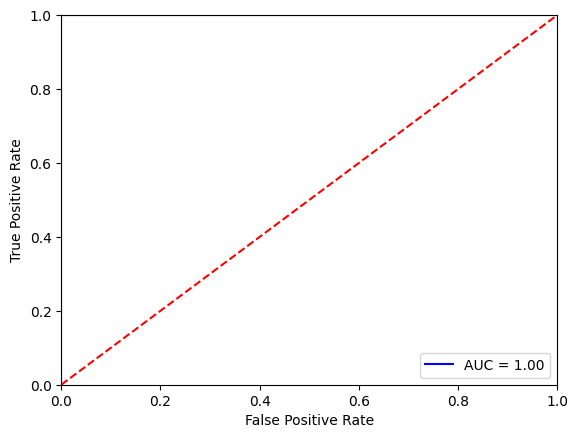

-----
EER Threshold:  0.7957064509391785
EER = 0.0


In [149]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# binary classifier predictions
y_pred_prob = provide_predictions(x_train, x_val)

# classes for testing
y_val_bin = np.ones((len(y_val), 1))

for i,classvalue in enumerate(y_val):
  if(classvalue!=auth_class):
    y_val_bin[i] = 0
# ROC curve
fpr, tpr, thresholds = roc_curve(y_val_bin, y_pred_prob)
roc_auc = auc(fpr, tpr)
print("-----")
print("Plotting the Receiving Operating Characteristic curve:")

# Plot ROC curve
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Finding the EER threshold
fnr = 1 - tpr
eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
print("-----")
print("EER Threshold: ", eer_threshold)
EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
print("EER = " + str(EER))

# Testing phase

In [150]:
predictDVector(x_train, auth_class, x_test, y_test, threshold=eer_threshold, verbose=False)

-----------------------
 --- Testing Results ---
True Positive Rate: 15/15 (100.0%)
False Positive Rate: 0/45 (0.0%)
Precision: 1.0
Recall: 1.0
******************
Total correct 60/60
Accuracy on this dataset: 1.0
F1-Score on this dataset: 1.0


1.0